In [12]:
import pandas as pd
import sys
sys.path.append('../')
from data_preprocessing import Preprocess

#word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


#sgdclssifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import numpy as np

In [4]:
df=pd.read_csv('../../data/dialects_data.csv')

#preprocess
preprocess = Preprocess(df)
cleaned_df=preprocess.preprocess()



In [6]:
Word2VecModel = Word2Vec(vector_size=300, window=5, min_count=1, workers=4)
Word2VecModel.build_vocab(cleaned_df['text'].apply(lambda x: x.split()))
Word2VecModel.train(cleaned_df['text'].apply(lambda x: x.split()), total_examples=Word2VecModel.corpus_count, epochs=30)


(56310399, 60344460)

In [7]:
Embedding = Word2VecModel.wv


In [13]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return pd.DataFrame([np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                                     or [np.zeros(self.dim)], axis=0) for words in X])

In [14]:
#train sgdclassifier
X = cleaned_df['text']
y = cleaned_df['dialect']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
sgd=SGDClassifier()
sgd.fit(MeanEmbeddingVectorizer(Embedding).transform(X_train), y_train)
y_pred=sgd.predict(MeanEmbeddingVectorizer(Embedding).transform(X_test))


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

In [19]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))

Accuracy:  0.33416821797258417
F1 score:  0.3284760960301893


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

In [20]:
confusion_matrix(y_test, y_pred)

c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

array([[6211,  438,  888,   13, 3934],
       [1718,  753,  616,   10, 2481],
       [2353,  431, 1459,   24, 3001],
       [ 883,  102,  367,   24,  907],
       [1101,  150,  250,    5, 1426]], dtype=int64)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

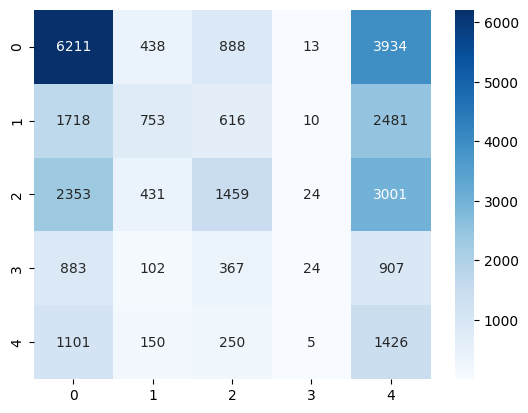

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()